In [28]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

def read_snap(folder_path, snap):
    file_path = os.path.join(folder_path, f'snap_{snap}.h5')
    with h5py.File(file_path, 'r') as hf:
        pos = np.array(hf['pos'])
        vel = np.array(hf['vel'])
        ids = np.array(hf['id'])-1
    return pos, vel, ids

def calculate_median_center(points):
    return np.median(points, axis=0)

def reducing_sphere_approach(pos_data, initial_radius=256, min_radius=1):
    radius = initial_radius
    progenitor_positions = []
    while radius >= min_radius:
        distances = cdist(pos_data, [calculate_median_center(pos_data)])
        points_within_sphere = pos_data[distances.flatten() <= radius]
        median_center = calculate_median_center(points_within_sphere)
        progenitor_positions.append(median_center)
        pos_data = points_within_sphere
        radius /= 2  

    return progenitor_positions

def find_rotation_angle(final_progenitor_position):
    # Calculate the angle between the final progenitor position and the positive x-axis
    angle = np.arctan2(final_progenitor_position[1], final_progenitor_position[0])
    return angle

def rotate_points(points, angle):
    Rxy = np.array([[np.cos(angle), np.sin(angle), 0],
                    [-np.sin(angle), np.cos(angle), 0],
                    [0, 0, 1]])
    return np.dot(Rxy,points.T).T

def distance_from_progenitor(pos_data, progenitor_position):
    distances = np.linalg.norm(pos_data - progenitor_position, axis=1)
    return distances

folder_path = r"C:\Users\guygj\Downloads\FYP_2024_Guy\files\files"


In [29]:
snap = 0 
pos_data, vel, ids = read_snap(folder_path, snap)
progenitor_positions = reducing_sphere_approach(pos_data)
progenitor_positions = np.array(progenitor_positions)
final_progenitor_position = progenitor_positions[-1]
rotation_angle = find_rotation_angle(final_progenitor_position)
rotated_pos_data = rotate_points(pos_data,rotation_angle)

angles = np.zeros(len(pos_data))
wraps = np.zeros(len(pos_data))
angles[ids] = np.arctan2(rotated_pos_data[:,1],rotated_pos_data[:,0])
prev_angles = angles*1.

# Track when each star's ID leaves a 1kpc radius about the current progenitor location
left_progenitor_snap = np.zeros(len(pos_data))

In [30]:
for snap in range(1, 115, 1):
    pos_data, vel, ids = read_snap(folder_path, snap)
    progenitor_positions = reducing_sphere_approach(pos_data)
    progenitor_positions = np.array(progenitor_positions)
    final_progenitor_position = progenitor_positions[-1]
    rotation_angle = find_rotation_angle(final_progenitor_position)
    rotated_pos_data = rotate_points(pos_data, rotation_angle)
    angles[ids] = np.arctan2(rotated_pos_data[:,1], rotated_pos_data[:,0])
    mask = np.where((angles > np.pi/2) & (prev_angles < -np.pi/2))[0] 
    wraps[mask] = wraps[mask]-1
    mask = np.where((prev_angles > np.pi/2) & (angles < -np.pi/2))[0] 
    wraps[mask] = wraps[mask]+1
    # print(np.count_nonzero(wraps))
    prev_angles = angles.copy()

    # Calculate distance of each star from the current progenitor
    distances = distance_from_progenitor(pos_data, final_progenitor_position)
    
    # Store the snapshot when each star leaves a 1kpc radius about the current progenitor location
    for star_id, distance in zip(ids, distances):
        if distance > 2.0 and left_progenitor_snap[star_id] == 0:
            left_progenitor_snap[star_id] = snap

angles += 2*np.pi*wraps

#print(angles)

Tracked star IDs: [367977 524242 771084 681418 860223 654492 198120 375887 591165 617619]


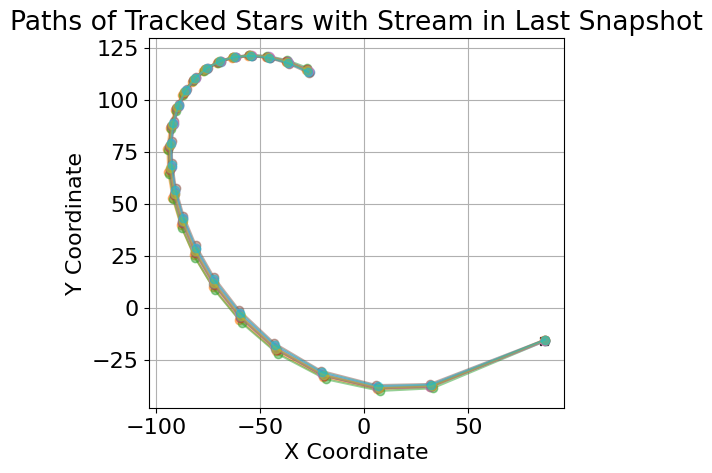

In [31]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# Define your functions here
folder_path = r"C:\Users\guygj\Downloads\FYP_2024_Guy\files\files"
snap = 115
pos_data, vel, ids = read_snap(folder_path, snap)
progenitor_positions = reducing_sphere_approach(pos_data)
final_progenitor_position = progenitor_positions[-1]

# Find stars within the progenitor's vicinity in the first snapshot
distances = distance_from_progenitor(pos_data, final_progenitor_position)
candidate_star_indices = np.where(distances <= 1.0)[0]

# Randomly select 5 stars from the candidates
if len(candidate_star_indices) >= 10:
    random_star_indices = np.random.choice(candidate_star_indices, 10, replace=False)
    tracked_star_ids = ids[random_star_indices]
    print("Tracked star IDs:", tracked_star_ids)
else:
    print("Insufficient stars within 1kpc radius of the progenitor position.")

star_positions = {snap: {star_id: pos_data[np.where(ids == star_id)[0][0]] for star_id in tracked_star_ids}}

for snap in range(118, 140):
    pos_data, vel, ids = read_snap(folder_path, snap)
    
    for tracked_star_id in tracked_star_ids:
        if tracked_star_id in ids:
            tracked_star_index = np.where(ids == tracked_star_id)[0][0]
            tracked_star_position = pos_data[tracked_star_index]
            if snap not in star_positions:
                star_positions[snap] = {}
            star_positions[snap][tracked_star_id] = tracked_star_position

# Plot the paths of the tracked stars across snapshots
if len(star_positions) > 0:
    for tracked_star_id in tracked_star_ids:
        star_snapshots = sorted(star_positions.keys())
        star_coords = [star_positions[snap][tracked_star_id] for snap in star_snapshots if tracked_star_id in star_positions[snap]]
        star_coords = np.array(star_coords)
        plt.plot(star_coords[:, 0], star_coords[:, 1], marker='o', linestyle='-',alpha = 0.5, label=f'Tracked Star {tracked_star_id}')

    # Plot the stream in the last snapshot
    pos_data, vel, ids = read_snap(folder_path, 140)
    #plt.scatter(pos_data[:, 0], pos_data[:, 1], color='red', alpha=0.1, label='Stream in Last Snapshot')
    plt.scatter(final_progenitor_position[0], final_progenitor_position[1], color='black', marker='x', label='Initial Progenitor Position')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Paths of Tracked Stars with Stream in Last Snapshot')
    plt.gca().set_aspect('equal', adjustable='box')
    #plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No tracked stars found.")


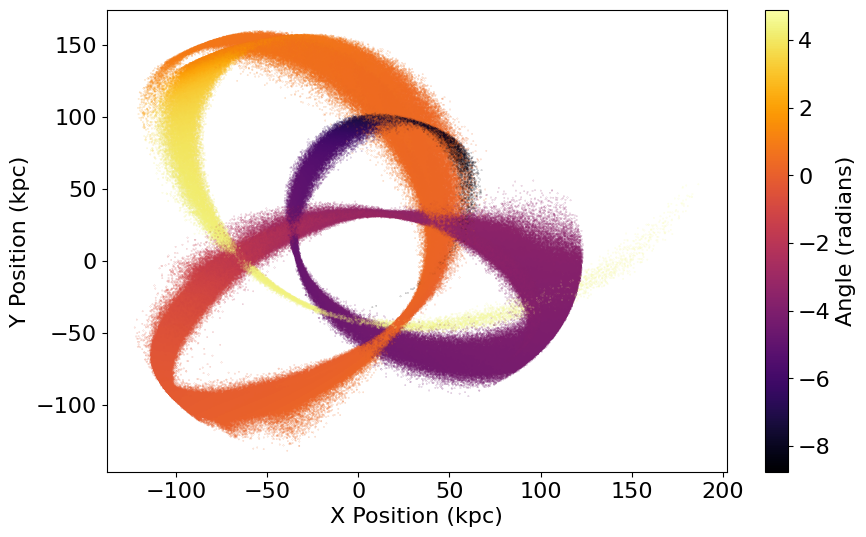

In [49]:
# Define a custom colormap with a smaller range of colors
plt.rcParams['font.size'] = 16

plt.figure(figsize=(10, 6))
sorted_indices = np.argsort(ids)
sorted_pos_data = pos_data[sorted_indices]
sorted_angles = angles[sorted_indices]
plt.scatter(sorted_pos_data[:, 0], sorted_pos_data[:, 1], s=0.01, c=angles, cmap='inferno')
plt.xlabel('X Position (kpc)')
plt.ylabel('Y Position (kpc)')
#plt.title('Star Positions with Color Gradient Based on Angles')
plt.colorbar(label='Angle (radians)')
plt.show()

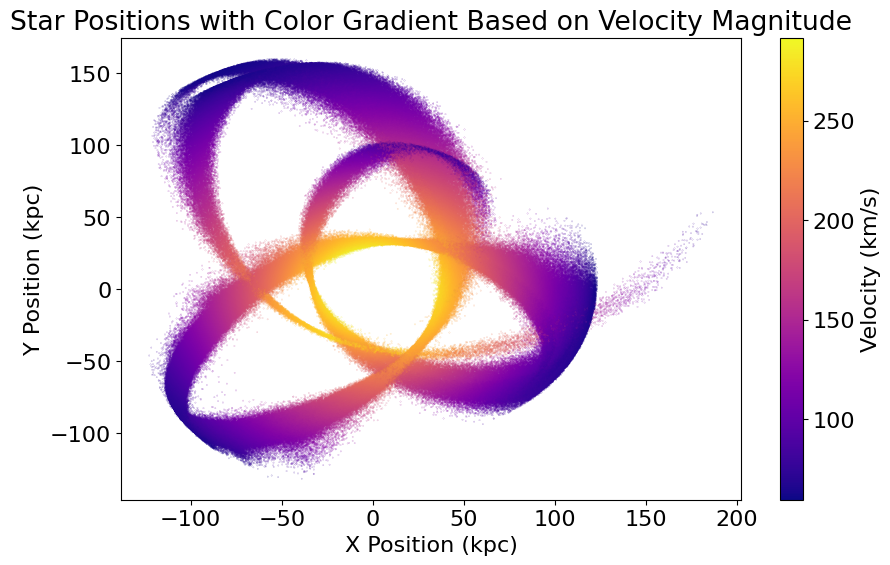

In [51]:
from matplotlib.colors import Normalize
sorted_indices = np.argsort(ids)
sorted_pos_data = pos_data[sorted_indices]
sorted_vel_data = vel[sorted_indices]
vel_magnitude = np.linalg.norm(sorted_vel_data, axis=1)

# Normalize velocity magnitude data
norm = Normalize(vmin=np.min(vel_magnitude), vmax=np.max(vel_magnitude))
normalized_vel_magnitude = norm(vel_magnitude)
plt.figure(figsize=(10, 6))
plt.scatter(sorted_pos_data[:, 0], sorted_pos_data[:, 1], s=0.01, c=vel_magnitude, cmap='plasma')
plt.xlabel('X Position (kpc)')
plt.ylabel('Y Position (kpc)')
plt.title('Star Positions with Color Gradient Based on Velocity Magnitude')
plt.colorbar(label='Velocity (km/s)')
plt.show()

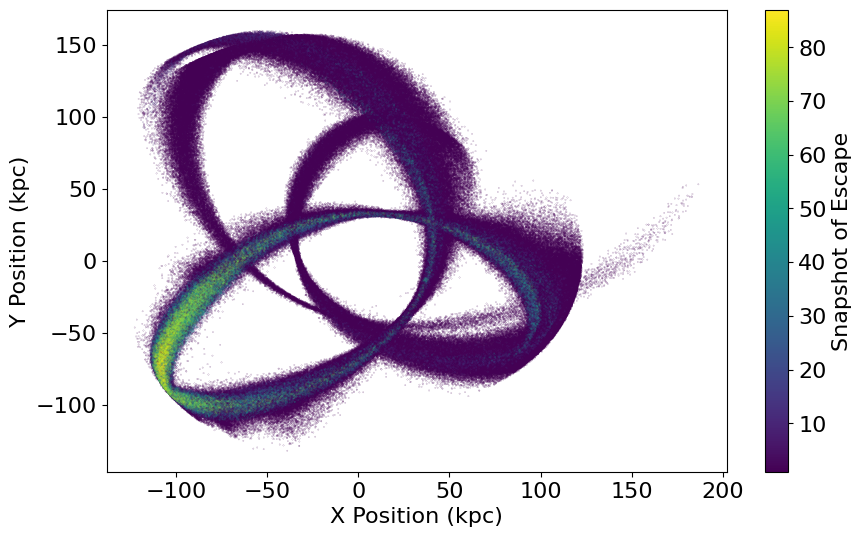

In [53]:
# Plot colormap of the snapshots when stars left the progenitor
log_left = (left_progenitor_snap)
plt.figure(figsize=(10, 6))
plt.scatter(sorted_pos_data[:, 0], sorted_pos_data[:, 1], s=0.01, c=log_left, cmap='viridis')
plt.xlabel('X Position (kpc)')
plt.ylabel('Y Position (kpc)')
plt.colorbar(label='Snapshot of Escape')
plt.show()

In [35]:

lower_lim = 60
upper_lim = 100

# Now, filter the data based on the snapshot indices between 1 and 50
filtered_ang_data = angles[(left_progenitor_snap.astype(int) >= lower_lim) & (left_progenitor_snap.astype(int) <= upper_lim)]
filtered_pos_data = sorted_pos_data[(left_progenitor_snap.astype(int) >= lower_lim) & (left_progenitor_snap.astype(int) <= upper_lim)]
filtered_vel_data = sorted_vel_data[(left_progenitor_snap.astype(int) >= lower_lim) & (left_progenitor_snap.astype(int) <= upper_lim)]

# Print the left_progenitor_snap array
print("left_progenitor_snap:", left_progenitor_snap)
print(angles)
print(filtered_ang_data)


left_progenitor_snap: [ 1.  2.  1. ... 18.  1. 42.]
[ 0.23828177  0.12925277 -3.23006243 ...  0.0508019   0.20879947
 -2.85177092]
[-0.18993906 -0.10160692 -2.7866509  ... -0.1839498  -0.39111369
 -0.17278471]


In [36]:
from rotation_matrix import obs_from_pos6d

In [37]:
# transformation matrix
a_g = np.array([[-0.0548755604, +0.4941094279, -0.8676661490],
                [-0.8734370902, -0.4448296300, -0.1980763734],
                [-0.4838350155, 0.7469822445, +0.4559837762]])

l, b, dist, pml, pmb, vlsr = obs_from_pos6d(sorted_pos_data,sorted_vel_data,R0=0,R_phi12_radec = a_g.T,reflex_correction = True)
# Calculate observed galactic coordinates and other parameters
lf, bf, distf, pmlf, pmbf, vlsrf = obs_from_pos6d(filtered_pos_data, filtered_vel_data,R0=0,R_phi12_radec=a_g.T, reflex_correction=True)


Text(0, 0.5, 'Y Position')

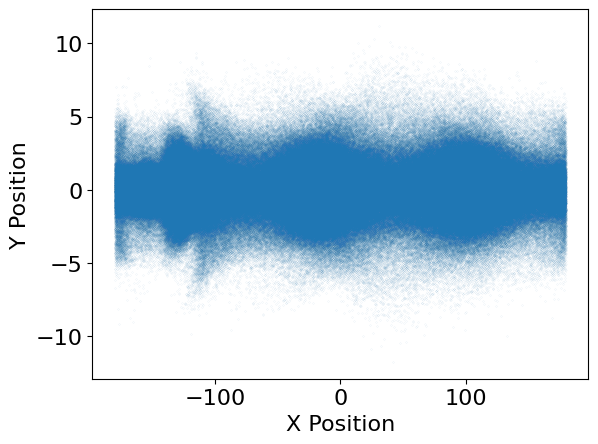

In [38]:
plt.scatter(l, b, s= 0.001)
plt.xlabel('X Position')
plt.ylabel('Y Position')

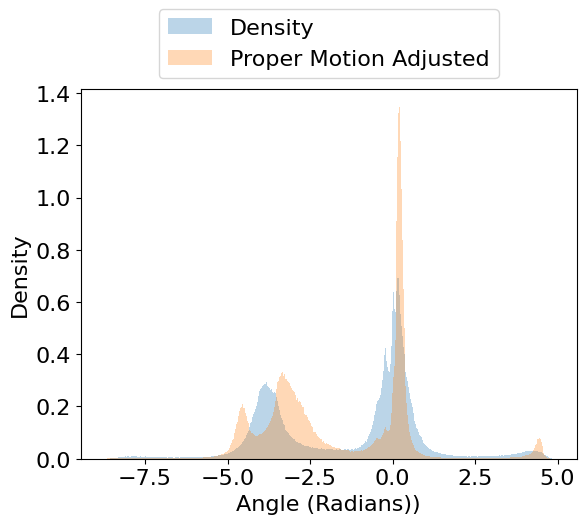

In [39]:
plt.hist(angles,bins=500,alpha = 0.3, density=True, label="Density");
plt.hist(angles,weights=np.fabs(pml/np.cos(b*np.pi/180)),bins=500,alpha=0.3,density=True, label="Proper Motion Adjusted");

#plt.hist(filtered_ang_data,bins=500,alpha = 0.3, density=True,label="Filtered snap < 10");
#plt.hist(filtered_ang_data,weights=np.fabs(pmlf/np.cos(bf*np.pi/180)),bins=500,alpha=0.3,density=True, label="Filtered snap < 10 Proper Motion Adjusted");

#plt.xscale('log')  # Set x-axis to log scale
#plt.yscale('log')  # Set y-axis to log scale
plt.xlabel('Angle (Radians))')
plt.ylabel('Density')
plt.legend(bbox_to_anchor=(0.5, 1), loc='lower center')

In [40]:
# Find stars within the progenitor's vicinity in the first snapshot
distances = distance_from_progenitor(pos_data, final_progenitor_position)
candidate_star_indices = np.where(distances >= 1000.0)[0]
#candidate_star_indices = np.where((distances >= 200.0) & ((angles >= -np.pi/2) | (angles <= np.pi/2)))[0]

# Remove stars within the progenitor's vicinity from the data
prefiltered_ang_data = np.delete(angles, candidate_star_indices)
prefiltered_pos_data = np.delete(sorted_pos_data, candidate_star_indices, axis=0)
prefiltered_vel_data = np.delete(sorted_vel_data, candidate_star_indices, axis=0)
prefiltered_left_progenitor_snap = np.delete(left_progenitor_snap.astype(int), candidate_star_indices, axis=0)


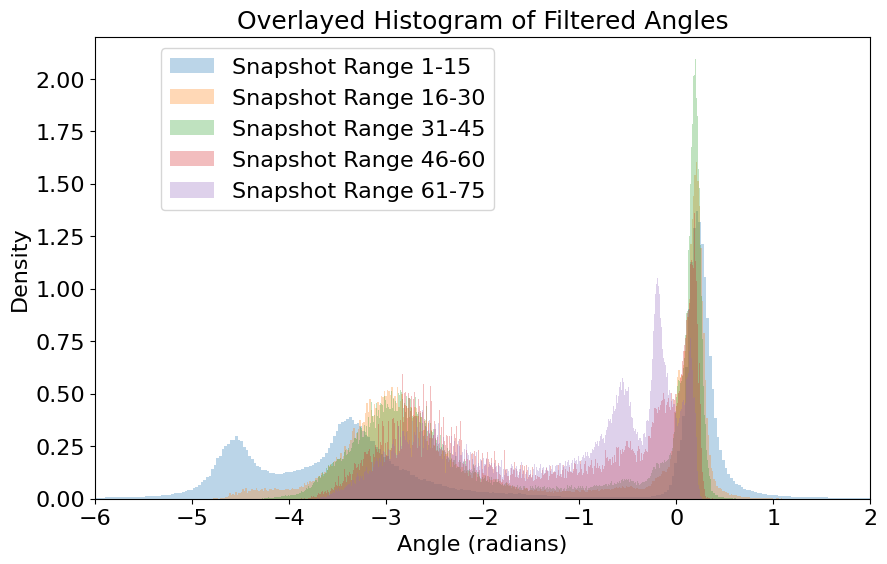

In [41]:
import matplotlib.pyplot as plt

# Create figure and axes outside the loop
fig, ax = plt.subplots(figsize=(10, 6))

limits = [(1, 15), (16, 30), (31, 45), (46, 60), (61, 75)]

# Iterate over each snapshot and filter the data
for i, (lower_lim, upper_lim) in enumerate(limits):
    filtered_ang_data = prefiltered_ang_data[(prefiltered_left_progenitor_snap.astype(int) >= lower_lim) & (prefiltered_left_progenitor_snap.astype(int) <= upper_lim)]
    filtered_pos_data = prefiltered_pos_data[(prefiltered_left_progenitor_snap.astype(int) >= lower_lim) & (prefiltered_left_progenitor_snap.astype(int) <= upper_lim)]
    filtered_vel_data = prefiltered_vel_data[(prefiltered_left_progenitor_snap.astype(int) >= lower_lim) & (prefiltered_left_progenitor_snap.astype(int) <= upper_lim)]
    
    # Calculate the variables using the filtered data
    l, b, dist, pml, pmb, vlsr = obs_from_pos6d(filtered_pos_data, filtered_vel_data, R0=0, R_phi12_radec=a_g.T, reflex_correction=True)
    
    # Plot histogram for the filtered angle data, overlaying each plot
    ax.hist(filtered_ang_data, weights=np.fabs(pml/np.cos(b*np.pi/180)), bins=500, alpha=0.3, density=True, label=f"Snapshot Range {lower_lim}-{upper_lim}")

# Set labels, legend, and title
ax.set_xlabel("Angle (radians)", fontsize=16)
ax.set_xlim(-6,2)
ax.set_ylabel("Density", fontsize=16)
ax.legend(bbox_to_anchor=(0.3, 0.6), loc='lower center')
ax.set_title("Overlayed Histogram of Filtered Angles", fontsize=18)

plt.show()
